In [1]:
%matplotlib inline

In [2]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import copy

# load the DICOM files
import os
PathDicom = "/data/Pat1/CT_scan/DICOM/PA000001/ST000001/SE000005"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".zip" not in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
# print(len(lstFilesDCM))
files = []
# print('glob: {}'.format(sys.argv[1]))
for fname in lstFilesDCM:
#     print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

# print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

# print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)
print(len(slices))

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

array_3d = copy.deepcopy(img3d)

785


In [3]:
import scipy.ndimage
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float,(list(scan[0].PixelSpacing))+ [scan[0].SliceThickness] )
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print ("Shape before resampling\t", array_3d.shape)
imgs_after_resamp, spacing = resample(array_3d, slices, [1,1,1])
print ("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (512, 512, 785)
Shape after resampling	 (500, 500, 981)


In [4]:
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def plot_3d(p, label=None):

    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    # p = image.transpose(2,1,0)
    # p = image.transpose(1,0,2)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    if label is not None:
        verts, faces, _, _ = measure.marching_cubes_lewiner(label)
        mesh = Poly3DCollection(verts[faces], alpha=0.20)
        face_color = 'red'
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes_lewiner(p)
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

In [5]:
def convert_global_aix_to_net_pos(point, spacing, origin):
    point['x'] = (point['x'] - origin[0]) / spacing[0]
    point['y'] = (point['y'] - origin[1]) / spacing[1]
    point['z'] = (point['z'] - origin[2]) / spacing[2]
    return point

In [6]:
path_csv = '/data/Pat1/POD_JR_9060K_Landmarks_femur.csv'
import pandas as pd
data = pd.read_csv(path_csv, names=["Name", "x", "y", "z"])
data = convert_global_aix_to_net_pos(data, spacing, slices[0].ImagePositionPatient)

mark_img = np.zeros(imgs_after_resamp.shape)
# x = np.zeros(img_shape)

cude_size = 3
for i in range(-cude_size, cude_size):
    for j in range(-cude_size, cude_size):
        for k in range(-cude_size, cude_size):
            for index, row in data.iterrows():
                mark_img[i+int(row['x']), j+int(row['y']), k+int(row['z'])] = 5200

In [7]:
imgs_after_resamp[imgs_after_resamp <= 1500] = 0

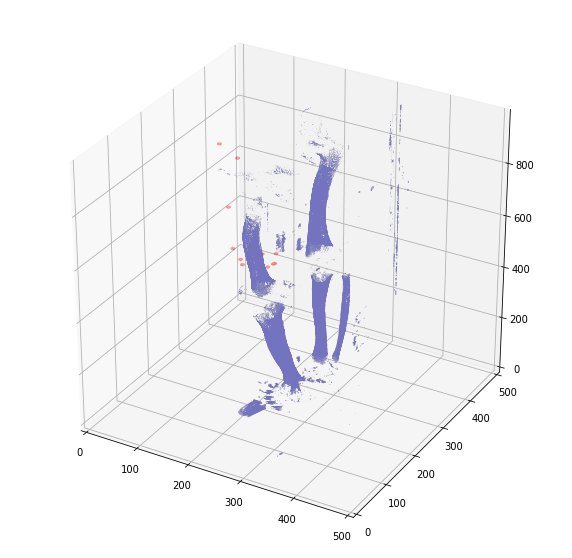

In [8]:
plot_3d(imgs_after_resamp, mark_img)

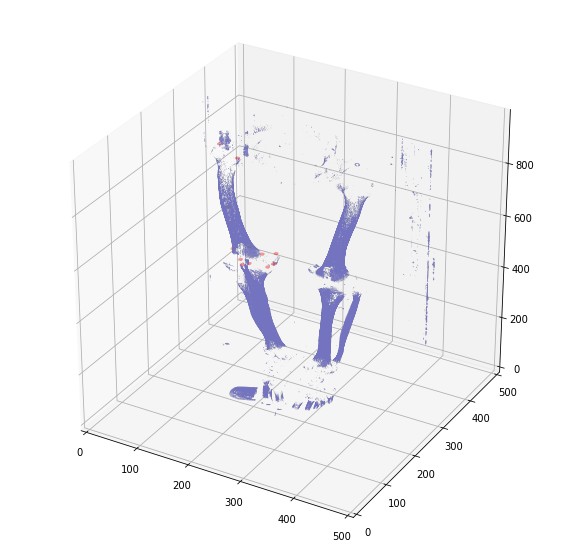

In [9]:
plot_3d(imgs_after_resamp.transpose(1,0,2), mark_img)

In [16]:
import ipyvolume as ipv

fig = ipv.figure()
vol = ipv.volshow(imgs_after_resamp.transpose(1,0,2))
lbl = ipv.volshow(mark_img, extent=vol.extent)

In [ ]:
ipv.save('show.html')